In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from models.model_fpgan import FPGANSynthesizer
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy, get_roc_auc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
data = pd.read_csv("D:/Datasets/census/adult.csv")
data['income']=data['income'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})
data["sex"] = data["sex"].map({"Male": 0, "Female":1})

# Create Married Column - Binary Yes(1) or No(0)
data["marital.status"] = data["marital.status"].replace(['Never-married','Divorced','Separated','Widowed'], 'Single')
data["marital.status"] = data["marital.status"].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 'Married')
data["marital.status"] = data["marital.status"].map({"Married":1, "Single":0})
data["marital.status"] = data["marital.status"].astype(int)

# Drop the data you don't want to use
data.drop(labels=["workclass","education","occupation","relationship","race","native.country"], axis = 1, inplace = True)
#data = data.drop(columns=[' Net Income Flag', ' Liability-Assets Flag'])
data.head()

,age,fnlwgt,education.num,marital.status,sex,capital.gain,capital.loss,hours.per.week,income
0,90,77053,9,0,1,0,4356,40,0
1,82,132870,9,0,1,0,4356,18,0
2,66,186061,10,0,1,0,4356,40,0
3,54,140359,4,0,1,0,3900,40,0
4,41,264663,10,0,1,0,3900,40,0


In [5]:
data.shape

(32561, 9)

In [6]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())

In [7]:
target = 'income'

In [8]:
X = data.drop(columns=[target])
y = data[target]

In [14]:
#model_ctgan = CTGANSynthesizer(epochs=25)
#model_ctgan = DPCTGANSynthesizer(verbose=True)
model_ctgan = FPGANSynthesizer(verbose=True, epochs=25)
#original_losses, tranformed_privacies, losses = model_ctgan.fit(data)
model_ctgan.fit(data)

Epoch 1, Loss G: -0.3270,Loss D:  0.5978
Epoch 2, Loss G: -0.0845,Loss D: -0.9628
Epoch 3, Loss G: -0.1648,Loss D: -0.4145
Epoch 4, Loss G: -0.1250,Loss D: -0.1240
Epoch 5, Loss G: -0.2207,Loss D: -0.1288
Epoch 6, Loss G: -0.0551,Loss D: -0.6515
Epoch 7, Loss G: -0.0201,Loss D: -0.4739
Epoch 8, Loss G:  0.0215,Loss D: -0.6534
Epoch 9, Loss G:  0.0477,Loss D: -0.9662
Epoch 10, Loss G:  0.0178,Loss D: -0.8442
Epoch 11, Loss G:  0.0279,Loss D: -0.5234
Epoch 12, Loss G: -0.0063,Loss D: -0.4764
Epoch 13, Loss G: -0.0124,Loss D: -0.3488
Epoch 14, Loss G: -0.0197,Loss D: -0.2748
Epoch 15, Loss G: -0.0350,Loss D: -0.1906
Epoch 16, Loss G: -0.0735,Loss D: -0.0363
Epoch 17, Loss G: -0.1226,Loss D:  0.3368
Epoch 18, Loss G: -0.1255,Loss D:  0.0894
Epoch 19, Loss G: -0.1062,Loss D:  0.0507
Epoch 20, Loss G: -0.0826,Loss D:  0.2460
Epoch 21, Loss G: -0.0490,Loss D: -0.0969
Epoch 22, Loss G: -0.0809,Loss D: -0.0116
Epoch 23, Loss G: -0.1228,Loss D: -0.1775
Epoch 24, Loss G: -0.1041,Loss D: -0.0985
E

([array(0.00551208, dtype=float32),
  array(0.00136376, dtype=float32),
  array(0.00966759, dtype=float32),
  array(0.00969635, dtype=float32),
  array(0.00685408, dtype=float32),
  array(0.01724401, dtype=float32),
  array(0.01978306, dtype=float32),
  array(0.034309, dtype=float32),
  array(0.03445637, dtype=float32),
  array(0.05031579, dtype=float32),
  array(0.0541444, dtype=float32),
  array(0.06725083, dtype=float32),
  array(0.08594503, dtype=float32),
  array(0.10305414, dtype=float32),
  array(0.12080268, dtype=float32),
  array(0.13281387, dtype=float32),
  array(0.1263449, dtype=float32),
  array(0.15194504, dtype=float32),
  array(0.13980307, dtype=float32),
  array(0.1668943, dtype=float32),
  array(0.15291917, dtype=float32),
  array(0.13821533, dtype=float32),
  array(0.13365664, dtype=float32),
  array(0.06304955, dtype=float32),
  array(0.04136522, dtype=float32),
  array(-0.00552486, dtype=float32),
  array(-0.03654137, dtype=float32),
  array(-0.05178171, dtype=floa

In [15]:
from utils.utils import save_models
save_models(model_ctgan, 'fpgan25', 'census')

In [33]:
from utils.utils import load_models
model_ctgan = load_models('fpgan25', 'cansus')

In [34]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [35]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [36]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.1046061]


## Fidelity

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42, stratify=y_syn)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test)

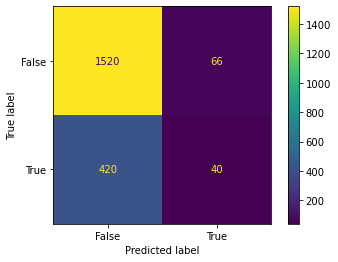

In [59]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [60]:
percentage, class1_ratio, class2_ratio = eval_fidelity(rr_pred, fr_pred)

In [61]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  0.7956989247311828
Accuracy of synthetic data:  0.9188660801564027


In [62]:
rr_score = get_roc_auc(y_test, rr_pred)
fr_score = get_roc_auc(y_test, fr_pred)
print("ROC AUC of real data: ", rr_score)
print("ROC AUC of synthetic data: ", fr_score)

ROC AUC of real data:  0.782989368355222
ROC AUC of synthetic data:  0.5330479987492183


In [63]:
print(class1_ratio, class2_ratio)

0.7577268195413759 0.07604562737642585


## Final plot

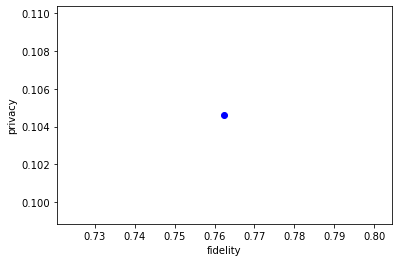

0.7624633431085044 [0.1046061]


In [64]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)